In [7]:
from binance_market_module import BinanceMarketModule
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import statsmodels as sm
import scipy.stats as st
pd.options.mode.chained_assignment = None  # default='warn'

In [8]:
fg = (20, 3)

In [9]:
bmod = BinanceMarketModule('spot')

In [10]:
interval = '1d'
start = '2017-01-01'
end = '2023-01-26'
btc_df = bmod.retrieveOHLCV('BTCUSDT', interval, start, end)
eth_df = bmod.retrieveOHLCV('ETHUSDT', interval, start, end)
btc_df = btc_df.set_index('close_ts')[['close']].rename(columns={'close': 'btc'})
eth_df = eth_df.set_index('close_ts')[['close']].rename(columns={'close': 'eth'})
df = btc_df.join(eth_df)

In [38]:
# create class to generate signal
class StatArb:
    
    # constructor
    def __init__(self, df: pd.DataFrame):
        # initialise variables
        self.df = df
        self.position_state = 0
        self.position_states = []
        self.transactions = 0
        self.transactions_count = []
        self.transaction_happen = 0
        self.transaction_happen_records = []
        self.transaction_cost = []
        self.transaction_cost_param = 0
        
        # check for required number of assets
        if df.shape[1] == 2:
            data = df.copy()
            # generate relevant figures for statistical arbitrage
            assets = list(data.columns)
            rename = {k: v for k, v in zip(assets, ['x', 'y'])}
            data.rename(columns = rename, inplace=True)
            for symbol in list(data.columns):
                data['norm_' + symbol] = data[symbol] / data[symbol][0]
                data['pct_change_' + symbol] = data[symbol].pct_change()
                
            # generate price ratio x/y
            symbols = list(data.columns)
            
            # ratio = x / y
            data['ratio'] = data['norm_' + symbols[0]] / data['norm_' + symbols[1]]
            self.data = data
            self.symbols = data
        else:
            print('Module requires 2 assets')
            
    # reset class
    def reset(self):
        self.__init__(self.df)
        
    # generate signal based on rolling window, mean reversion
    def generate_signal(self, window: int, confidence_level: float):
        self.window = window
        self.confidence_level = confidence_level
        
        # process data, respecting the window
        self.p_data = self.data.copy()
        self.p_data['ratio_mean'] = self.p_data['ratio'].rolling(self.window).mean()
        self.p_data['ratio_std'] = self.p_data['ratio'].rolling(self.window).std()
        self.p_data = self.p_data[window:]
        
        # generate signal using internal function; and apply
        self.p_data['signal_strength'] = self.p_data.apply(lambda row: StatArb.signal_strength(row['ratio'],
                                                                                       row['ratio_mean'],
                                                                                       row['ratio_std'],
                                                                                       self.confidence_level), axis=1)
        return self.p_data
    
    # based on signal strength, obtain positions
    def generate_positions(self, transaction_cost: float = 0):
        # iterate through processed data, and generate positions
        # position state = 1 --> short X, long Y
        # position state = -1 --> long X, short Y
        
        self.transaction_cost = transaction_cost
        
        for i in range(len(self.p_data)):

            # extract data from a row
            values = self.p_data.iloc[i, :]
            signal_strength = values['signal_strength']
            ratio_mean = values['ratio_mean']
            ratio = values['ratio']
            self.transaction_happen = 0

            # if there is no current position, check for signal strength
            if self.position_state == 0:
                if signal_strength > 0:
                    self.position_state = 1
                    self.transactions += 1
                    self.transaction_happen = 1
                elif signal_strength < 0:
                    self.position_state = -1
                    self.transactions += 1
                    self.transaction_happen = 1
                else:
                    self.position_state = 0
            # if a position already exists, check whether we can close it
            elif self.position_state == 1:

                # if ratio has fallen below the mean, we can close the position
                if ratio < ratio_mean:
                    self.position_state = 0 # close position
                    self.transactions += 1
                    self.transaction_happen = 1
                # otherwise, maintain the position
                else:
                    self.position_state = 1 # maintain position
                    self.transaction_happen = 0                    

            # if a position already exists, check whether we can close it
            elif self.position_state == -1:
                if ratio > ratio_mean:
                    self.position_state = 0 # close position
                    self.transactions += 1
                    self.transaction_happen = 1
                else:
                    self.position_state = -1 # maintain position
                    self.transaction_happen = 0
            else:
                print('Position State should only be 1 or -1')

            # store position states and transaction costs
            self.position_states.append(self.position_state)
            self.transactions_count.append(self.transactions)
            self.transaction_happen_records.append(self.transaction_happen)
        
        # append to processed data
        period_shift = 1
        self.p_data['position_state'] = self.position_states
        self.p_data['adj_position_state'] = self.p_data['position_state'].shift(periods=period_shift) # should shift by 1
        self.p_data['transaction_cost'] = self.transaction_happen_records
        self.p_data['transaction_cost'] = self.p_data['transaction_cost'].apply(lambda x: x * self.transaction_cost)
        self.p_data['adj_transaction_cost'] = self.p_data['transaction_cost'].shift(periods=period_shift) # should shift by 1
        self.p_data['cumulative_transactions'] = self.transactions_count
        
        # calculate returns
        self.p_data['period_return'] = self.p_data['adj_position_state'] * self.p_data['pct_change_x'] - self.p_data['adj_position_state'] * self.p_data['pct_change_y'] - self.p_data['adj_transaction_cost']
        self.p_data['cum_return'] = (self.p_data['period_return'] + 1).cumprod() - 1
        
    # obtain net position
    def generate_net_portfolio(self):
        # positive if overall long, negative if overall short        
        net_portfolio = 0
        all_net_portfolio = []
        for i in range(len(self.p_data)):
            values = self.p_data.iloc[i, :]
            position_state = values['adj_position_state']
            if position_state == 0:
                net_portfolio = 0
            else:
                position_change = position_state * ((1 + values['pct_change_x']) - (1 + values['pct_change_y']))
                net_portfolio = ((1 + net_portfolio) * (1 + position_change)) - 1

            # store net position
            all_net_portfolio.append(net_portfolio)

        # update net position
        self.p_data['net_portfolio'] = all_net_portfolio
        
    # plot performance   
    def plot_all(self, fg: tuple = (20, 3)):
        z_score = StatArb.get_z_score(self.confidence_level)
        d = self.p_data.copy()
        
        plt.figure(figsize=fg)
        plt.plot(d['ratio'])
        plt.plot(d['ratio_mean'])
        plt.fill_between(d.index, d['ratio_mean'] - z_score * d['ratio_std'], d['ratio_mean'] + z_score * d['ratio_std'], color='lightblue')
        plt.title('Ratio Time Series, with Confidence Interval')

        plt.figure(figsize=fg)
        plt.plot(d['norm_x'])
        plt.plot(d['norm_y'])
        plt.title('Normalised X and Y')

        plt.figure(figsize=fg)
        plt.plot(d[['cum_return']])
        plt.title('Cumulative Returns')

        plt.figure(figsize=fg)
        plt.plot(d['period_return'])
        plt.title('Period Returns')

        plt.figure(figsize=fg)
        plt.plot(d['signal_strength'])
        plt.title('Signal Strength')

        plt.figure(figsize=fg)
        plt.plot(d[['position_state']])
        plt.title('Position States')

        plt.figure(figsize=fg)
        plt.plot(d['cumulative_transactions'])
        plt.title('Cumulative Transactions')

        plt.figure(figsize=fg)
        plt.plot(d['net_portfolio'])
        plt.title('Net Portfolio Position')
        plt.show()
        
    # generate results summary
    def results(self):
        # generate results for portfolio, as well as individual assets
        
        sharpe = self.p_data['period_return'].mean() / self.p_data['period_return'].std() * np.sqrt(365)
        sortino = self.p_data['period_return'].mean() / self.p_data[self.p_data['period_return'] < 0]['period_return'].std() * np.sqrt(365)
        max_drawdown = StatArb.max_drawdown(self.p_data.dropna()['cum_return'] + 1)
        
        # constructing output from constituent assets
        sharpe_x = self.p_data['pct_change_x'].mean() / self.p_data['pct_change_x'].std() * np.sqrt(365)
        sortino_x = self.p_data['pct_change_x'].mean() / self.p_data[self.p_data['pct_change_x'] < 0]['pct_change_x'].std() * np.sqrt(365)
        max_drawdown_x = StatArb.max_drawdown(self.p_data.dropna()['norm_x'] + 1)
        
        sharpe_y = self.p_data['pct_change_y'].mean() / self.p_data['pct_change_y'].std() * np.sqrt(365)
        sortino_y = self.p_data['pct_change_y'].mean() / self.p_data[self.p_data['pct_change_y'] < 0]['pct_change_y'].std() * np.sqrt(365)
        max_drawdown_y = StatArb.max_drawdown(self.p_data.dropna()['norm_y'] + 1)        
        
        # constructing output from portfolio
        dic = {}
        dic['confidence_level'] = self.confidence_level
        dic['window'] = int(self.window)
        dic['transaction_cost'] = self.transaction_cost
        dic['sharpe'] = sharpe
        dic['sortino'] = sortino
        dic['max_drawdown'] = max_drawdown
        dic['sharpe_x'] = sharpe_x
        dic['sortino_x'] = sortino_x
        dic['max_drawdown_x'] = max_drawdown_x
        dic['sharpe_y'] = sharpe_y
        dic['sortino_y'] = sortino_y
        dic['max_drawdown_y'] = max_drawdown_y
        
        results = pd.DataFrame.from_dict(dic, orient='index', columns=['value'])
        return results
        
        
    # generate z_score
    @staticmethod
    def get_z_score(confidence_level: float):
        confidence_input = 1 - (1-confidence_level)/2     # bounding to 0.999
        z_score = st.norm.ppf(confidence_input)
        return z_score
        
    # generate buy and sell signal using mean and std
    @staticmethod
    def signal_strength(ratio, ratio_mean, ratio_std, confidence_level):
        z_score = StatArb.get_z_score(confidence_level)

        # generate lower and upper bounds
        lower_bound = ratio_mean - (z_score * ratio_std)
        upper_bound = ratio_mean + (z_score * ratio_std)

        # generate signal based on lower and upper bound
        if ratio > upper_bound:
            signal_strength = (ratio - upper_bound) / upper_bound
        elif ratio < lower_bound:
            signal_strength = (ratio - lower_bound) / lower_bound
        else:
            signal_strength = 0
        return signal_strength
    
    
    @staticmethod
    def max_drawdown(prices):
        # solving using dynamic programming, where we can achieve linear time complexity
        # initiatise max drawdown and running peak
        all_max_drawdowns = []
        all_drawdowns = []
        max_drawdown = 0
        running_peak = 0

        for price in prices:
            # obtain new peak
            running_peak = max(running_peak, price)

            # obtain new drawdown and calculate new max drawdown
            drawdown = (running_peak - price) / running_peak
            max_drawdown = max(max_drawdown, drawdown)
            all_max_drawdowns.append(max_drawdown)
            all_drawdowns.append(drawdown)

        return max_drawdown

    
    def plot_ratio(self):
        if self.data:
            self.data[['ratio']].plot(figsize=(20, 5))
            plt.title('Price Ratio')
            plt.ylabel('Normalised X / Normalised Y')
            plt.show()
            

In [39]:
mod = StatArb(df)

In [44]:
confidence = 0.9
window = 7
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(0.001)
mod.generate_net_portfolio()
mod.results()

,value
confidence_level,0.900000
window,7.000000
transaction_cost,0.001000
sharpe,1.209027
sortino,1.403577
max_drawdown,0.357849
sharpe_x,0.731363
sortino_x,0.978292
max_drawdown_x,0.720567
sharpe_y,0.758617


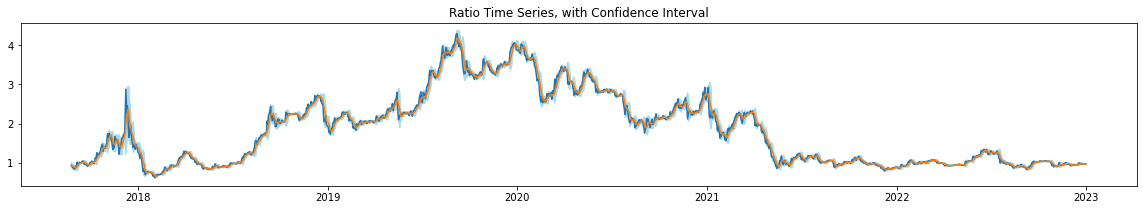

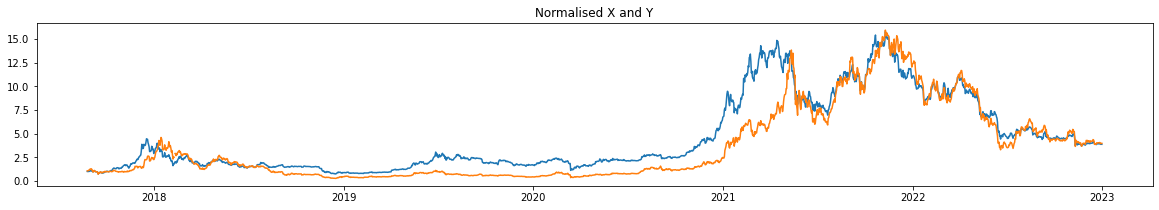

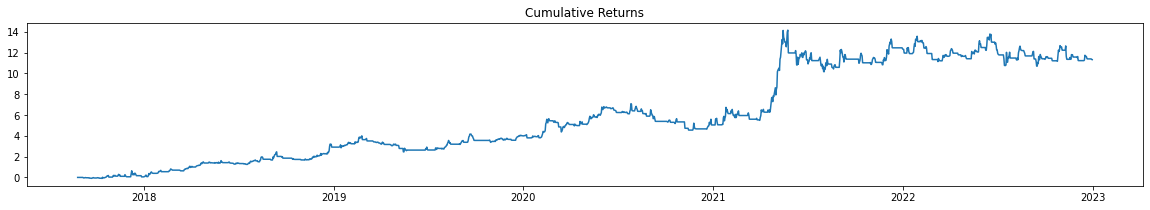

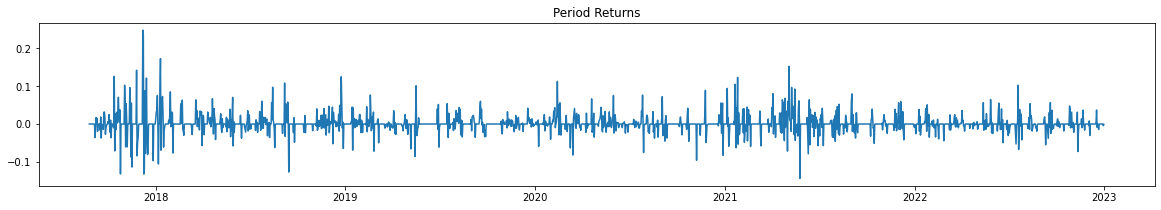

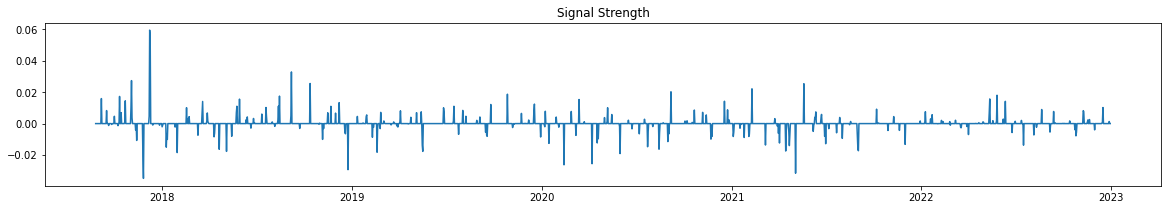

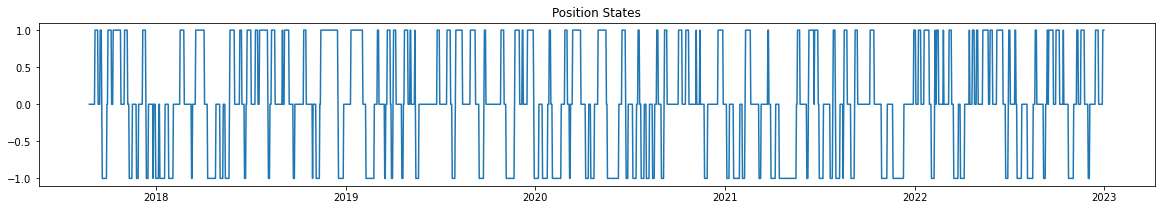

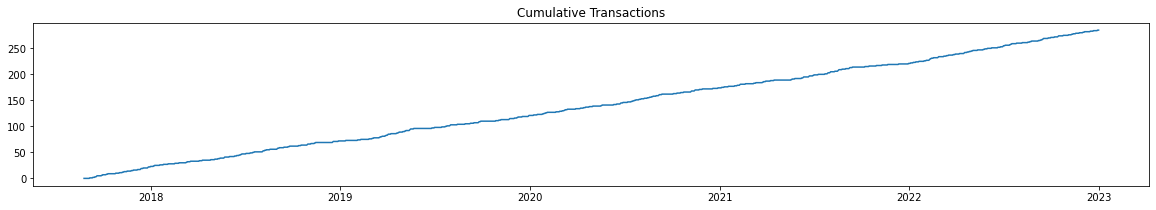

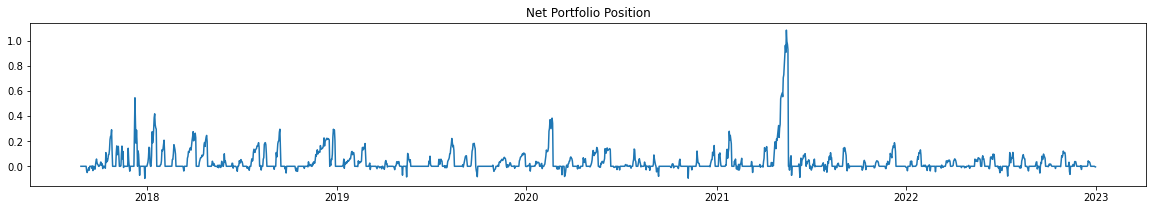

In [45]:
mod.plot_all()

In [46]:
confidence = 0.95
window = 14
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(0.001)
mod.generate_net_portfolio()
mod.results()

,value
confidence_level,0.950000
window,14.000000
transaction_cost,0.001000
sharpe,1.205408
sortino,1.297734
max_drawdown,0.537771
sharpe_x,0.708145
sortino_x,0.947352
max_drawdown_x,0.720567
sharpe_y,0.721885


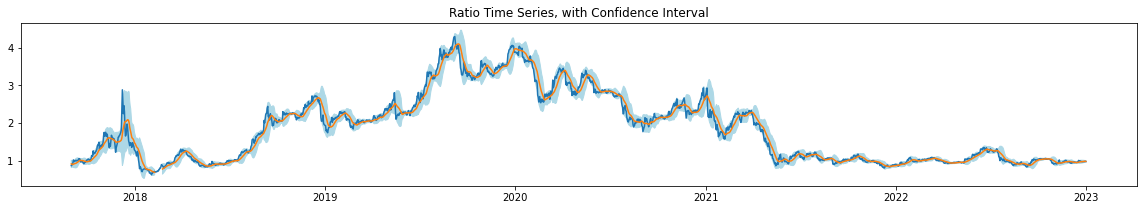

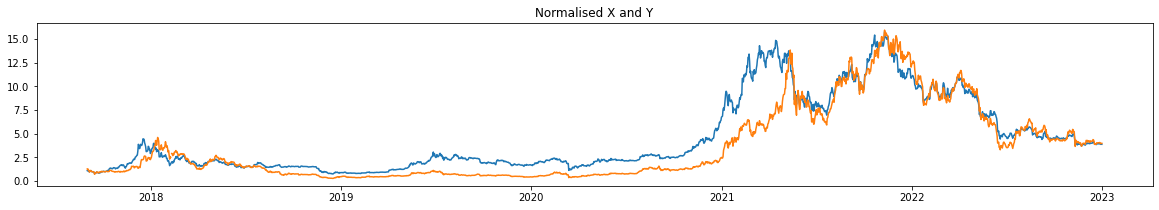

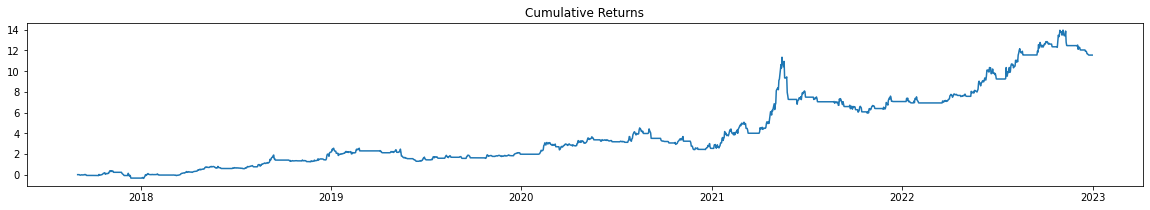

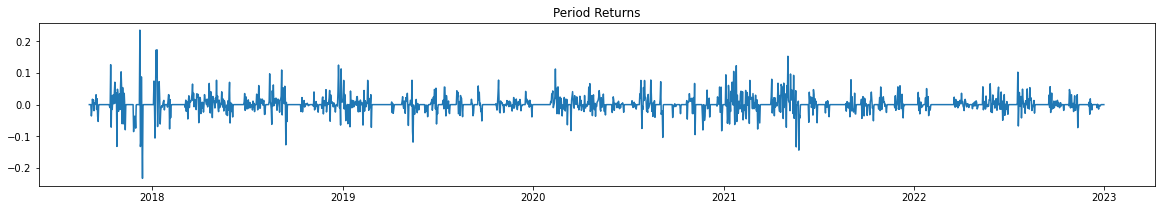

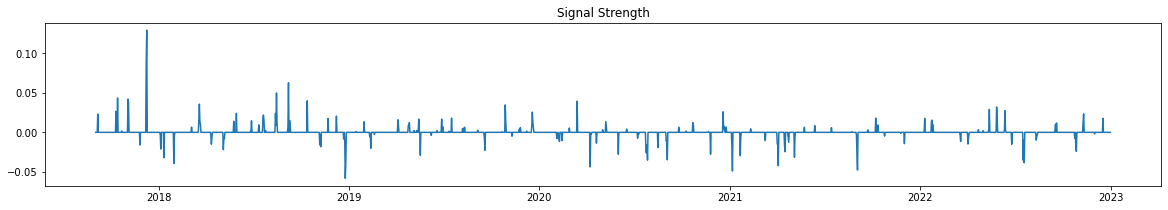

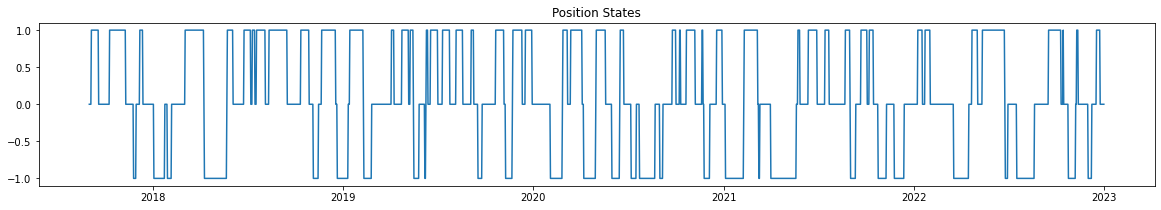

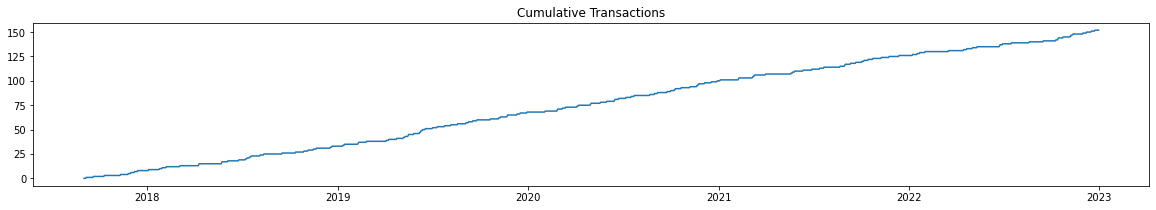

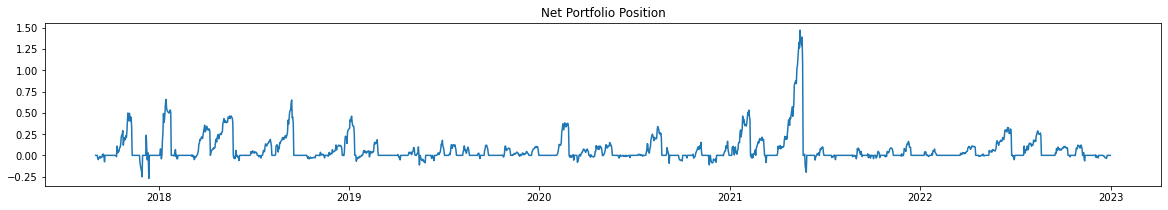

In [47]:
mod.plot_all()